In [1]:
import sys
sys.path += ["../src"]
import utils
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.pyplot import subplots as sbp 
from importlib import reload
import jl_vae
import shapely
import geopandas as gpd
import jl_nflows_geo_coordinates_2 as nfg
from jl_nflows_geo_coordinates import load_nf as load_dict

from _51_abm_functions import cod_prov_abbrv_df

# Global Spatial Autocorrelation
from spatial_autocorrelation import get_moransI, moransI_scatterplot, hypothesis_testing
# Local Spatial Autocorrelation
from spatial_autocorrelation import get_localMoransI, LISA_scatterplot

#### Load functions
Copy past functions to assign Hedonic Price

In [2]:
#%% Import libraries
import pandas as pd
import numpy as np
import sys
import pyfixest as pf
from tqdm import tqdm
import pickle

from pyfixest.estimation import feols
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

sys.path += ['../src/'] 
import utils
import config


# 40 seconds
abm_path = "ISP_data_for_ABM/ISP_ABM_up_to_2024_08_0001.csv"
data = pd.read_csv(jl_vae.path_intermediate + abm_path, index_col = 0)
geo_dict = jl_vae.load_geo_data()

# these need to be added to the generated data for predicting with hedonic regression
year_erogaz = [f'year_erogaz_{u}' for u in [u for u in range(2016, 2025)]] 
# Trained Hedonic Regression
train_path = '/data/housing/data/intermediate/HedonicRegressionABM/reg_risk_OMI_id.pkl'
# Load ISP data for the ABM and clean it 
data_path = '/data/housing/data/intermediate/ISP_data_for_ABM/ISP_ABM_up_to_2024_08.csv'
isp = pd.read_csv(data_path,dtype=str,encoding='latin1',na_values=config.default_missing)

drop_col = ['floor_numeric','NUM_MQ_SUPERF_COMM','COD_CAT_CATASTALE','year_erogaz']
isp = isp.drop(columns=drop_col)
isp = utils.CorrectTypes_ABM(isp)

def HedonicRegression_PriceTrain (train_data,sp_fix_eff,save):
    """
    Function to compute the hedonic price of the houses in the synthetic population
    Inputs:
     - train_data: ISP data
     - sp_fix_eff: spatial fixed effects (we start using PRO_COM)
     - save: flag that is True if you want to save the regression parameters in this file f'/data/housing/data/intermediate/HedonicRegressionABM/reg_risk_{sp_fix_eff}.pkl'. 

    Outputs:
     - reg_risk: regression objetc
    """
    # Drop colinearity variables
    drop_coliniarity= ['ANNO_COSTRUZIONE_1500_1965','Medium_energy_class',
                        'COD_CAT_A_04_05','floor_0.0','year_erogaz_2016']
    train_data = train_data.drop(columns=drop_coliniarity)

    # Add dummies to formula: 
    floor_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('floor_')]))
    year_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('year_erogaz_20')]))
    energy_class_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('_energy_class')]))
    ANNO_COSTRUZIONE_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('ANNO_COSTRUZIONE')]))
    COD_CAT_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('COD_CAT_')]))

    dummies_vec = COD_CAT_dummies + '+' + ANNO_COSTRUZIONE_dummies + '+' + energy_class_dummies + ' + ' + floor_dummies + '+' + year_dummies

    # Regression specification
    base_features = 'flag_garage + flag_pertinenza + flag_air_conditioning + flag_multi_floor +' + dummies_vec
    mq_feature = 'log_mq' 

    eq_regr_risk = 'log_price ~ scenario_Risk +' + mq_feature + '+' + base_features + '|' +  sp_fix_eff  # + C(month_erogaz) year_erogaz_prov +
    
    # Train regression
    reg_risk = feols(fml=eq_regr_risk, data=train_data, drop_intercept=False ,vcov = {"CRV1":sp_fix_eff})
    if save==True:
        model_state = {"_beta_hat": reg_risk._beta_hat,
                    "_coefnames": reg_risk._coefnames,
                    "_se": reg_risk._se,
                    "_tstat": reg_risk._tstat,
                    "_pvalue": reg_risk._pvalue,
                    "_conf_int": reg_risk._conf_int,
                    "_vcov": reg_risk._vcov,
                    "_fml": reg_risk._fml,
                    "_sumFE": reg_risk._sumFE,
                    "_fixef": reg_risk._fixef,
                    "_fixef_dict": reg_risk._fixef_dict,
                    "_data": reg_risk._data}
        with open(f'/data/housing/data/intermediate/HedonicRegressionABM/reg_risk_{sp_fix_eff}.pkl', 'wb') as handle:
            pickle.dump(model_state, handle)

    return reg_risk

def Predict_function(isp,train_path,test_data):
    """
    Function to estimate the hedonic price of a house. 

    Input variables:
        -isp: data from ISP data (used to initialize the regression model)
        - train_path: path to coefficients af the trained model
        - test_data: data for which you want to estimate the home hedonic price

    Output:
        - test_data: same Dataframe as the input with the estimated hedonic price corrected by inflation
    and flood_risk effects (``price_corrected``). 
    """

    # Initialise dummy regresion
    reg_risk = HedonicRegression_PriceTrain(isp.sample(1000),'PRO_COM',save=False)

    # Update reg_risk with good params
    with open(train_path, 'rb') as handle:
        model_state = pickle.load(handle)

    reg_risk._beta_hat = model_state["_beta_hat"]
    reg_risk._coefnames = model_state["_coefnames"]
    reg_risk._se = model_state["_se"]
    reg_risk._tstat = model_state["_tstat"]
    reg_risk._pvalue = model_state["_pvalue"]
    reg_risk._conf_int = model_state["_conf_int"]
    reg_risk._vcov = model_state["_vcov"]
    reg_risk._fml = model_state["_fml"]
    reg_risk._sumFE = model_state["_sumFE"]
    reg_risk._fixef = model_state["_fixef"]
    reg_risk._fixef_dict = model_state["_fixef_dict"]
    reg_risk._data = model_state["_data"]

    test_data['log_price_estimation'] = reg_risk.predict(test_data)

    
    # Correct price estimations with Risk coefficient and average Inflation
    _, df_coeff = utils.ImportantCoefficients(reg_risk,['Risk'])

    # Risk correction
    test_data['price_corrected'] = test_data['log_price_estimation'] - (df_coeff.loc['scenario_Risk','Coefficient']*test_data['scenario_Risk'])

    # Correct inflation
    df_year,_ = utils.ImportantCoefficients(reg_risk,['year']) # av_inflation
    avg_inflation = df_year.Coefficient.mean()
    
    for i in df_year.index:
        test_data['price_corrected'] = test_data['price_corrected'] - (df_year.loc[i,'Coefficient']*test_data[i])
    test_data['price_corrected'] = test_data['price_corrected'] + avg_inflation
    
    # Remove log and drop unnecessary columns
    test_data['price_corrected'] = np.exp(test_data['price_corrected'])
    test_data.drop(columns='log_price_estimation',inplace=True)
    
        
    return test_data
    


In [8]:
def add_cat_features(df):
    df["energy_class"] = df[[u for u in df.columns if "_energy" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]
    df["COD_CAT"] = [u[8:] for u in df[[u for u in df.columns if "COD_CAT_" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]]
    df["anno_costruzione"] = [u[17:] for u in df[[u for u in df.columns if "ANNO_COSTRUZIONE" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]]
    return df


### One province

In [ ]:
# paths for importing synthetic populations

# choose the province
prov = "AN" # AO
# get the cod prov (number)
cod_prov = cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].item()

# all trained models have these settings
date_nf = "241203"
# without the prices
# date_vae = "240107"
# synth_pops = jl_vae.path_pop_synth + f"pop_samples/pop_synth_with_hedonic_price_250110"
# with the prices
date_vae = "250709price_"
synth_pops = jl_vae.path_pop_synth + f"pop_samples"

date_data = "250110"

real_pops = jl_vae.path_pop_synth + f"pop_samples/pop_real_with_hedonic_price"

date_95 = "250703"
date_data = "250110"

vae_data = "full"

# date_abl = "250523" 
# date_abl = "25071" 
date_abl = "250710" 
ablation_pops = jl_vae.path_pop_synth + f"pop_samples_ablation"

In [ ]:
# assign geographical features and prices ~1 minute
vae_loaded = jl_vae.load_vae_province(prov, 
                                      jl_vae.path_pop_synth + f"ablation_vae/settings_{vae_data}_{date_abl}{prov}.pkl",
                                      jl_vae.path_pop_synth + f"ablation_vae/vae_{vae_data}_{date_abl}{prov}.pkl"
                                      )
len(vae_loaded.full_df)

df_abl = vae_loaded.get_sample_from_vae(nf_dict = None, n_samples = 100000, seed = 800)
df_abl = utils.spatial_matching_ABM(df_abl,
                                       hydro_risk = geo_dict["hydro_risk"],
                                       census = geo_dict["census"],
                                       omi_og = geo_dict["omi_og"],
                                       cap = geo_dict["cap"]).rename({"GEO_LONGITUDINE_BENE_ROUNDED":"x", "GEO_LATITUDINE_BENE_ROUNDED":"y"})

# I set year erogazione as the last year we have 
df_abl[year_erogaz] = False
df_abl[year_erogaz[-1]] = True
# df_sample = df_sample.sample(n = len(df_real), replace = False)

# assign the hedonic price to all samples
#df_abl_with_price = Predict_function(isp, train_path, df_abl).rename(columns = {"GEO_LONGITUDINE_BENE_ROUNDED":"x", "GEO_LATITUDINE_BENE_ROUNDED":"y"})
# df_sample_with_price.to_csv(jl_vae.path_pop_synth + f"pop_samples/pop_synth_with_hedonic_price_250210/pop_synth_full_250210{prov}_{h}.csv")
        

ValueError: feols() failed after regex encountered the following value as a fixed effect:
 C(OMI_id)[A001_B1].
This may due to the presence of line separation and/or escape sequences within the string. If so, consider recoding the underlying string. Otherwise, please open a PR in the github repo!

In [11]:
# assign geographical features and prices ~1 minute
vae_loaded = jl_vae.load_vae_province(prov, 
                                      jl_vae.path_pop_synth + f"ablation_vae/settings_{vae_data}_{date_abl}{prov}.pkl",
                                      jl_vae.path_pop_synth + f"ablation_vae/vae_{vae_data}_{date_abl}{prov}.pkl"
                                      )
len(vae_loaded.full_df)

df_abl = vae_loaded.get_sample_from_vae(nf_dict = None, n_samples = 100000, seed = 800)
df_abl = utils.spatial_matching_ABM(df_abl,
                                       hydro_risk = geo_dict["hydro_risk"],
                                       census = geo_dict["census"],
                                       omi_og = geo_dict["omi_og"],
                                       cap = geo_dict["cap"]).rename({"GEO_LONGITUDINE_BENE_ROUNDED":"x", "GEO_LATITUDINE_BENE_ROUNDED":"y"})

# I set year erogazione as the last year we have 
df_abl[year_erogaz] = False
df_abl[year_erogaz[-1]] = True
# df_sample = df_sample.sample(n = len(df_real), replace = False)

# assign the hedonic price to all samples
# df_abl_with_price = Predict_function(isp, train_path, df_abl).rename(columns = {"GEO_LONGITUDINE_BENE_ROUNDED":"x", "GEO_LATITUDINE_BENE_ROUNDED":"y"})
#df_abl_with_price = df_abl.rename(columns = {"GEO_LONGITUDINE_BENE_ROUNDED":"x", "GEO_LATITUDINE_BENE_ROUNDED":"y"}).copy()
# df_sample_with_price.to_csv(jl_vae.path_pop_synth + f"pop_samples/pop_synth_with_hedonic_price_250210/pop_synth_full_250210{prov}_{h}.csv")
        

In [12]:
df_real = pd.read_csv(real_pops + f"/pop_real_full_250110{prov}.csv", index_col = 0)
# df_sample_all = pd.read_csv(synth_pops + f"/pop_synth_full_{date_vae}{prov}.csv", index_col = 0).query("prov_abbrv == @prov")
df_sample_all = pd.read_csv(synth_pops + f"/synthetic_pop_full_{date_vae}{prov}.csv", index_col = 0)

df_real = add_cat_features(df_real)
df_sample_all = add_cat_features(df_sample_all)
df_sample = df_sample_all.sample(n = int(len(df_real)), random_state = 1111)
# df_abl = pd.read_csv(ablation_pops + f"/synthetic_pop_{vae_data}_{date_abl}{prov}.csv", index_col = 0).sample(n = int(len(df_real)), replace = True, random_state = 1111)
#df_sample_abl = (df_abl_with_price.query("COD_PROV == @cod_prov").sample(n = int(len(df_real)), random_state = 1111)
#                 .assign(CAP = lambda x: x["CAP"].astype(int),
#                         PRO_COM = lambda x: x["PRO_COM"].astype(int)))

df_sample_abl = (df_abl.query("COD_PROV == @cod_prov").sample(n = int(len(df_real)), random_state = 1111)
                 .assign(CAP = lambda x: x["CAP"].astype(int),
                         PRO_COM = lambda x: x["PRO_COM"].astype(int),
                         x = lambda x: x["GEO_LONGITUDINE_BENE_ROUNDED"].astype(float),
                         y = lambda x: x["GEO_LATITUDINE_BENE_ROUNDED"].astype(float))) # I ADDED THIS (ARI)

In [13]:
len(df_sample), len(df_real), len(df_sample_abl)

(4222, 4222, 4222)

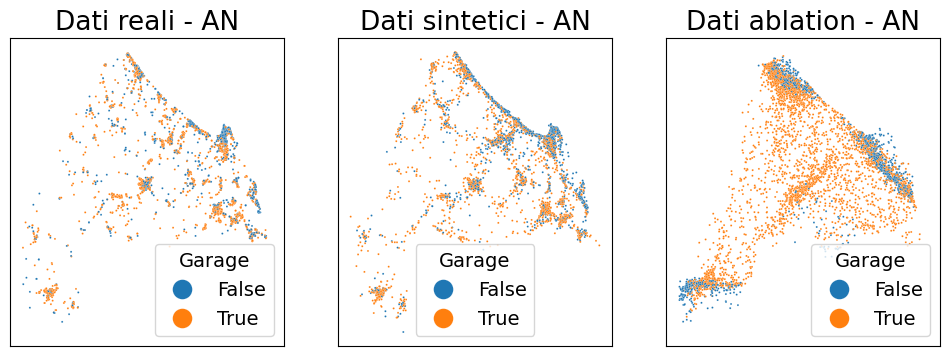

In [14]:
fig, axes = sbp(ncols = 3, figsize = (12,4), sharex = True, sharey = True)

for j,df_plot in enumerate([df_real.assign(flag_garage = lambda x: x["flag_garage"] == 1), df_sample, df_sample_abl[~df_sample_abl["PRO_COM"].isna()]]):
    sns.scatterplot(data = df_plot,
                    hue = "flag_garage", 
                    # hue = "flag_garage", 
                    x = "x", y = "y", s = 2, ax = axes[j])
    # axes[j].set_title(prov + " " + ["Real", "Synthetic"][j])
    axes[j].set_title("Dati " + ["reali", "sintetici", "ablation"][j] + " - " + prov, fontsize = 19)
    axes[j].get_xaxis().set_visible(False)
    axes[j].get_yaxis().set_visible(False)
# axes[0].legend().set_visible(False)
    axes[j].legend(fontsize = 14, markerscale = 10, title_fontsize = 14).set_title("Garage")

### Spatial Autocorrelation

In [ ]:
df_sample.columns

In [ ]:
# euclidean distance geographical coordinates
def compute_distance_matrix(df):
    M = np.array(df[["x", "y"]])
    D = (((np.repeat(M[:,:,None], len(df), axis = 2) - np.repeat(M[:,:,None], len(df), axis = 2).transpose(2,1,0))**2).sum(axis = 1))
    return D

# compute Morans index
# W is the distance weight, can be modified 
def compute_spatial_autocorrelation(df, var):
    D = compute_distance_matrix(df)
    W = np.exp(-D)
    return get_moransI(W,np.array(df[var]))


In [ ]:
var = "flag_garage"

In [ ]:
compute_spatial_autocorrelation(df_sample, var)

In [ ]:
compute_spatial_autocorrelation(df_real, var)

In [ ]:
compute_spatial_autocorrelation(df_sample_abl, var)

### Neighbors distribution

In [ ]:
D_sample = compute_distance_matrix(df_sample)
D_real = compute_distance_matrix(df_real)
D_sample_abl = compute_distance_matrix(df_sample_abl)
    

In [ ]:
np.var(D_sample), np.var(D_real), np.var(D_sample_abl)

In [ ]:
fig, axes = sbp(ncols = 3, figsize = (13, 3), sharex = True, sharey = True)
for i,D in enumerate([D_sample, D_real, D_sample_abl]):
    sns.histplot((D < 0.0001).sum(axis = 1), ax = axes[i], binwidth = 5)

### Correlation CAP

In [ ]:
fig, axes = sbp(ncols = 2, figsize = (7,3), sharex = True, sharey = True)
sns.scatterplot(data = df_sample["CAP"].value_counts().reset_index().merge(df_real["CAP"].value_counts().reset_index(), how = "outer", on = "CAP"),
                x = "count_x", y = "count_y", ax = axes[0])

sns.scatterplot(data = df_sample_abl["CAP"].value_counts().reset_index().merge(df_real["CAP"].value_counts().reset_index(), how = "outer", on = "CAP"),
                x = "count_x", y = "count_y", ax = axes[1])
axes[0].axline(xy1 = [0,0], xy2 = [1,1], color = "red", linestyle = "dashed", alpha = 0.3)
axes[1].axline(xy1 = [0,0], xy2 = [1,1], color = "red", linestyle = "dashed", alpha = 0.3)

In [ ]:
df_sample["CAP"].value_counts().reset_index().merge(df_real["CAP"].value_counts().reset_index(), how = "outer", on = "CAP")[["count_x", "count_y"]].corr().iloc[0,1]

In [ ]:
df_sample_abl["CAP"].value_counts().reset_index().merge(df_real["CAP"].value_counts().reset_index(), how = "outer", on = "CAP")[["count_x", "count_y"]].corr().iloc[0,1]

### Correlation PRO_COM

In [ ]:
fig, axes = sbp(ncols = 2, figsize = (7,3), sharex = True, sharey = True)
sns.scatterplot(data = df_sample["PRO_COM"].value_counts().reset_index().merge(df_real["PRO_COM"].value_counts().reset_index(), how = "outer", on = "PRO_COM"),
                x = "count_x", y = "count_y", ax = axes[0])

sns.scatterplot(data = df_sample_abl["PRO_COM"].value_counts().reset_index().merge(df_real["PRO_COM"].value_counts().reset_index(), how = "outer", on = "PRO_COM"),
                x = "count_x", y = "count_y", ax = axes[1])
axes[0].axline(xy1 = [0,0], xy2 = [1,1], color = "red", linestyle = "dashed", alpha = 0.3)
axes[1].axline(xy1 = [0,0], xy2 = [1,1], color = "red", linestyle = "dashed", alpha = 0.3)

In [ ]:
df_sample["PRO_COM"].value_counts().reset_index().merge(df_real["PRO_COM"].value_counts().reset_index(), how = "outer", on = "PRO_COM")[["count_x", "count_y"]].corr().iloc[0,1]

In [ ]:
df_sample_abl["PRO_COM"].value_counts().reset_index().merge(df_real["PRO_COM"].value_counts().reset_index(), how = "outer", on = "PRO_COM")[["count_x", "count_y"]].corr().iloc[0,1]

### Correlation OMI_id

In [ ]:
fig, axes = sbp(ncols = 2, figsize = (7,3), sharex = True, sharey = True)
sns.scatterplot(data = df_sample["OMI_id"].value_counts().reset_index().merge(df_real["OMI_id"].value_counts().reset_index(), how = "outer", on = "OMI_id"),
                x = "count_x", y = "count_y", ax = axes[0])

sns.scatterplot(data = df_sample_abl["OMI_id"].value_counts().reset_index().merge(df_real["OMI_id"].value_counts().reset_index(), how = "outer", on = "OMI_id"),
                x = "count_x", y = "count_y", ax = axes[1])
axes[0].axline(xy1 = [0,0], xy2 = [1,1], color = "red", linestyle = "dashed", alpha = 0.3)
axes[1].axline(xy1 = [0,0], xy2 = [1,1], color = "red", linestyle = "dashed", alpha = 0.3)

In [ ]:
df_sample["OMI_id"].value_counts().reset_index().merge(df_real["OMI_id"].value_counts().reset_index(), how = "outer", on = "OMI_id")[["count_x", "count_y"]].corr().iloc[0,1]

In [ ]:
df_sample_abl["OMI_id"].value_counts().reset_index().merge(df_real["OMI_id"].value_counts().reset_index(), how = "outer", on = "OMI_id")[["count_x", "count_y"]].corr().iloc[0,1]

# Earth mover distance

In [15]:
# Load shapefile of the region
def Find_province_shapefile(df_real):
    region= df_real.COD_REG.drop_duplicates().values[0].astype(str).zfill(2)

    region_shapefile = gpd.read_file(f'/data/housing/data/input/census/shapefiles_2011/R{region}_11_WGS84/R{region}_11_WGS84.shp')

    # filter prov
    df_real['COD_PROV']= df_real['PRO_COM'].apply(lambda x: '{:06d}'.format(int(x))).str[:3]
    cod_prov= df_real.COD_PROV.drop_duplicates().values[0]
    region_shapefile['PRO_COM'] = region_shapefile['PRO_COM'].apply(lambda x: '{:06d}'.format(int(x)))

    # keep shapefile of the province
    region_shapefile['COD_PROV']= region_shapefile['PRO_COM'].astype(str).str[:3]
    province_shapefile= region_shapefile.loc[region_shapefile.COD_PROV == cod_prov, "geometry"].reset_index().dissolve()
    province_shapefile.to_crs(epsg=4326, inplace=True)
    province_shapefile['index']=1
    province_shapefile.rename(columns={'index': 'in_province'}, inplace=True)  #needed for the next steps

    return province_shapefile


def Shuffle_attributes(data, attributes_shuffle, rand_geo, rand_attributes):
    if rand_attributes: 
        for attribute in attributes_shuffle: 
            if attribute !='num_homes': 
                data[attribute] = np.random.permutation(data[attribute].values)
        
    if rand_geo: 
        # Randomly shuffle the geometry of the homes
        geo =  province_shapefile.sample_points(len(data)).explode('geometry').reset_index(drop=True)
        data['x'] = geo.x
        data['y'] = geo.y
    return data


agg_rules = {
    'num_homes': 'sum',
    'flag_garage': 'mean',
    'flag_air_conditioning': 'mean',
    'flag_multi_floor': 'mean',
    'flag_pertinenza': 'mean',
    'log_mq': 'mean',
    'COD_CAT': 'first',
    'anno_costruzione': 'first',
    'energy_class': 'first',
}

# Cut province shapefile
province_shapefile = Find_province_shapefile(df_real)

# Generate 2 null models: 
# 1. Randomly shuffle the geographical coordinates of the homes
df_null = Shuffle_attributes(df_real.copy(deep=True).reset_index(drop=True), agg_rules.keys(), rand_geo = True, rand_attributes =False)

# 2. Randomly shuffle the attributes of the homes (keeping the coordinates constant)
df_feat_shuffle = Shuffle_attributes(df_real.copy(deep=True).reset_index(drop=True), agg_rules.keys(), rand_geo = False, rand_attributes =True)

# Visualisation histogram in grid

Text(0.5, 1, 'Distribution of flag_pertinenza in the province of AN')

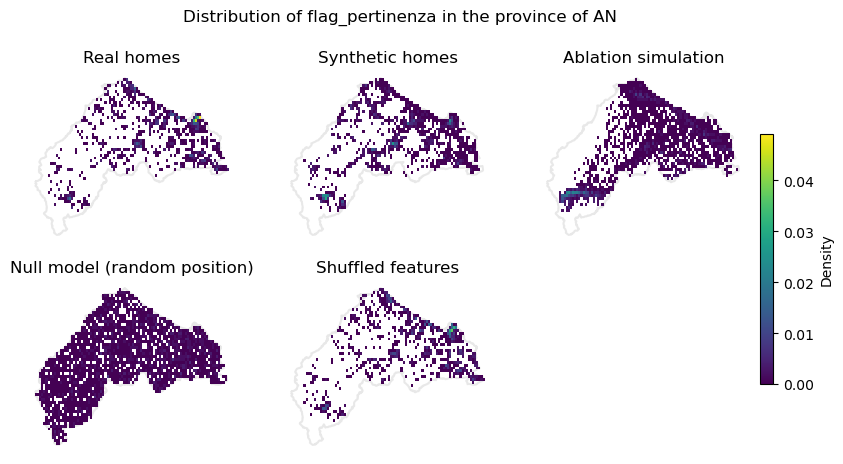

In [18]:
# 
def Aggregate_attribute_in_grid(data, grid, agg_rules, density =True ):
    '''
    Discretize space ina grid and count the number of homes in each grid cell.
    '''
    if type(data)== pd.DataFrame:
        # find coords
        geo_coordinates = gpd.points_from_xy(data.x, data.y,crs="EPSG:4326")
        data = gpd.GeoDataFrame(data, geometry=geo_coordinates)
    else: 
        data = data.set_geometry('geometry', crs="EPSG:4326")
        
    # Assing homes to grid cells
    merged = gpd.sjoin(data, grid, how='left', predicate='within')
    merged = merged.drop(columns='geometry').merge(grid, left_on='index_right', right_index=True, suffixes=('', '_grid'),how='left')
    
    merged['num_homes'] = 1 # add for counting homes

    # Aggregate by grid cell
    grid_aggregate = merged.groupby('index_right').agg(agg_rules).reset_index().rename(columns={'index_right': 'grid_id'})
    
    '''
    if metric == 'sum':
        grid_aggregate = merged.loc[:,[attribute,'index_right']].groupby('index_right').sum().reset_index().rename(columns={'index_right': 'grid_id'})
    elif metric == 'mean':
        grid_aggregate = merged.loc[:,[attribute,'index_right']].groupby('index_right').mean().reset_index().rename(columns={'index_right': 'grid_id'})'''
    grid_aggregate = gpd.GeoDataFrame(pd.merge(grid_aggregate, grid, left_on='grid_id',right_index=True, how='right')).reset_index(drop=True)
    #grid_aggregate.fillna(0, inplace=True)

    # Find grid cells inside the province
    grid_aggregate = gpd.sjoin(grid_aggregate, province_shapefile, how='left', predicate='intersects').drop(columns='index_right')
    grid_aggregate['in_province'] = grid_aggregate['in_province'].fillna(0)
    grid_aggregate.set_geometry('geometry', crs ="EPSG:4326",inplace=True)

    # normalise each column
    if density==True:
        for col in agg_rules.keys():
            grid_aggregate[col] = grid_aggregate[col] / grid_aggregate[col].sum()

    # convert to centroids
    # cast into matrix (grid with centroids)
    #grid_aggregate = grid_aggregate.set_index('geometry').reset_index()
    grid_aggregate['x'] = grid_aggregate['geometry'].apply(lambda x: x.centroid.x)
    grid_aggregate['y'] = grid_aggregate['geometry'].apply(lambda x: x.centroid.y)

    #grid_aggregate.set_geometry('geometry', crs ="EPSG:4326",inplace=True)

    #grid_aggregate = grid_list.pivot(index='y', columns='x', values=attribute).fillna(0)

    return grid_aggregate

# 
def Grid_count_homes(data,grid):
    '''
    Discretize space ina grid and count the number of homes in each grid cell.
    '''
    if type(data)== pd.DataFrame:
        # find coords
        geo_coordinates = gpd.points_from_xy(data.x, data.y,crs="EPSG:4326")
        data = gpd.GeoDataFrame(data, geometry=geo_coordinates)
    else: 
        data = data.set_geometry('geometry', crs="EPSG:4326")
        
    merged = gpd.sjoin(data, grid, how='left', predicate='within')
    merged = merged.drop(columns='geometry').merge(grid, left_on='index_right', right_index=True, suffixes=('', '_grid'),how='left')
    # count num homes per grid
    grid_count = merged.groupby('index_right').size().reset_index(name='num_homes')

    grid_count = gpd.GeoDataFrame(pd.merge(grid_count, grid, left_on='index_right',right_index=True, how='right')).reset_index(drop=True)

    # estimate probability from num_homes
    grid_count['num_homes'] = grid_count['num_homes'].astype(float)
    grid_count['num_homes'] = grid_count['num_homes'] / grid_count['num_homes'].sum()
    
    #grid_count['num_homes'] = grid_count['num_homes'].fillna(0)
    #grid_count = gpd.GeoDataFrame(merged.loc[:,['num_homes','index_right','geometry']]).dissolve(by="index_right", aggfunc="count")

    # plot 
    fig, ax = plt.subplots(figsize=(10,5))
    grid_count.plot(column='num_homes', ax=ax, legend=True, cmap='viridis', edgecolor='black')
    province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax, color='lightgray', markersize=0.1, alpha=0.5)

    # earth mover distance
    grid_count.fillna(0, inplace=True)
    grid_count= grid_count [['num_homes','geometry']]

    # convert to centroids
    # cast into matrix (grid with centroids)
    grid_count = grid_count.set_index('geometry').reset_index()
    grid_count['x'] = grid_count['geometry'].apply(lambda x: x.centroid.x)
    grid_count['y'] = grid_count['geometry'].apply(lambda x: x.centroid.y)
    centroids = grid_count[['x', 'y']].copy()

    grid_list = grid_count.set_index(['x', 'y']).reset_index()

    grid_count = grid_list.pivot(index='y', columns='x', values='num_homes').fillna(0)

    # find centroids

    #df_real.plot(ax=ax, color='red', markersize=0.1, alpha=0.5)
    return grid_count, centroids, grid_list

def create_grid(province_shapefile,cell_size_lat, cell_size_long):
 #total area for the grid
    xmin, ymin, xmax, ymax=province_shapefile.total_bounds
    # how many cells across and down
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size_long, cell_size_long ):
        for y0 in np.arange(ymin, ymax+cell_size_lat, cell_size_lat):
            # bounds
            x1 = x0+cell_size_long
            y1 = y0-cell_size_lat
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1)  )
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                    crs=crs)
    return grid

# Create grid for histogram
cell_size_lat = 0.01 # ~1kmx1km theoretically
cell_size_long = 0.01

grid = create_grid(province_shapefile, cell_size_lat, cell_size_long)

#fig, ax = plt.subplots(figsize=(10, 6))
#grid.boundary.plot(ax=ax, edgecolor='black', alpha=0.5)
#province_shapefile.plot(ax=ax, color='red', markersize=0.1, alpha=0.5)
# GRID AGGREGATE Generalised
agg_rules = {'flag_garage': 'sum', 
             'flag_air_conditioning': 'sum',
             'flag_multi_floor': 'sum',
             'num_homes': 'sum', 
             'log_mq': 'mean',
             'flag_pertinenza': 'sum'}

grid_real = Aggregate_attribute_in_grid(df_real, grid, agg_rules, density = True)
grid_sample = Aggregate_attribute_in_grid(df_sample, grid, agg_rules, density = True)
grid_ablation = Aggregate_attribute_in_grid(df_sample_abl, grid, agg_rules, density = True)
grid_null = Aggregate_attribute_in_grid(df_null, grid, agg_rules,density=True)
grid_shuffle= Aggregate_attribute_in_grid(df_feat_shuffle, grid, agg_rules, density = True)

# replace 0 by nan
#grid_real = grid_real.replace(0, np.nan)
#grid_sample = grid_sample.replace(0, np.nan)
#grid_null = grid_null.replace(0, np.nan)


attribute= 'flag_pertinenza' # 'flag_garage', 'flag_multi_floor', 'log_mq', 'flag_pertinenza'

max_cbar = np.max([np.max(grid_real[attribute]), np.max(grid_sample[attribute]), np.max(grid_null[attribute])])

fig, ax = plt.subplots(2,3,figsize=(10,5),sharex=True, sharey=True)
province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax[0][0], color='lightgray', markersize=0.1, alpha=0.5,zorder=1)
province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax[0][1], color='lightgray', markersize=0.1, alpha=0.5,zorder=1)
province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax[0][2], color='lightgray', markersize=0.1, alpha=0.5,zorder=1)
province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax[1][0], color='lightgray', markersize=0.1, alpha=0.5,zorder=1)
province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax[1][1], color='lightgray', markersize=0.1, alpha=0.5,zorder=1)

grid_real.loc[grid_real['in_province'] == 1].plot(column=attribute, cmap='viridis' ,ax=ax[0][0],zorder=3,vmax=max_cbar)
grid_sample.loc[grid_sample['in_province'] == 1].plot(column=attribute, cmap='viridis', ax=ax[0][1],zorder=3, vmax=max_cbar)
grid_ablation.loc[grid_ablation['in_province'] == 1].plot(column=attribute, cmap='viridis', ax=ax[0][2],zorder=3, vmax=max_cbar)
grid_null.loc[grid_null['in_province'] == 1].plot(column=attribute, cmap='viridis', ax=ax[1][0],zorder=3, vmax=max_cbar)
grid_shuffle.loc[grid_shuffle['in_province'] == 1].plot(column=attribute, cmap='viridis', ax=ax[1][1],zorder=3, vmax=max_cbar)
ax[0][0].set_title("Real homes")
ax[0][1].set_title("Synthetic homes")
ax[0][2].set_title("Ablation simulation")
ax[1][0].set_title("Null model (random position)")
ax[1][1].set_title("Shuffled features")

# remove axis and spines
for a in ax.flatten():
    a.set_axis_off()
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)

# make common colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.25, 0.013, 0.5]) #left, bottom, width, height
cbar = fig.colorbar(ax[0][0].collections[1], cax=cbar_ax)
cbar.ax.yaxis.set_label_position('right')
cbar.ax.yaxis.set_ticks_position('right')
cbar.set_label(f"Density")
# define max cbar

fig.suptitle(f"Distribution of {attribute} in the province of {prov}", fontsize=12, y=1, ha='center')

## Wasserstein distance (single homes): HOME LOCATION

In [ ]:
# Test wasserstein distance (no bins): Compare position homes in the grid
import ot 
from joblib import Parallel, delayed

n_projections = 10000
SWD = {'real_vs_sample' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_sample[['x', 'y']].to_numpy(), n_projections=n_projections),
            'real_vs_null' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_null[['x', 'y']].to_numpy(), n_projections=n_projections),
            'real_vs_abl' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_sample_abl[['x', 'y']].to_numpy(), n_projections=n_projections),
            'real_vs_shuffle' :  ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_feat_shuffle[['x', 'y']].to_numpy(), n_projections=n_projections),
            'sample_vs_null' : ot.sliced_wasserstein_distance(df_sample[['x', 'y']].to_numpy(),df_null[['x', 'y']].to_numpy(), n_projections=n_projections),
            'sample_vs_shuffle' : ot.sliced_wasserstein_distance(df_sample[['x', 'y']].to_numpy(),df_feat_shuffle[['x', 'y']].to_numpy(), n_projections=n_projections)}


SWD_df = pd.DataFrame.from_dict(SWD, orient='index', columns=['Wasserstein distance'])

SWD_df

# NOTE: Real vs shuffled is 0 because the coordinates are the same (only attributes are shuffled). 
# Sample vs shuffle is not 0 because we are only testing shuffle for the real data. So this is basically doing again sample vs real. 

,Wasserstein distance
real_vs_sample,0.007650
real_vs_null,0.166232
real_vs_abl,0.092015
real_vs_shuffle,0.000000
sample_vs_null,0.166599
sample_vs_shuffle,0.007664


## Wasserstein distance (single homes): OTHER ATTRIBUTES

In [20]:
df_sample

,flag_garage,flag_pertinenza,flag_air_conditioning,flag_multi_floor,log_mq,ANNO_COSTRUZIONE_1500_1965,ANNO_COSTRUZIONE_1965_1985,ANNO_COSTRUZIONE_1985_2005,ANNO_COSTRUZIONE_2005_2025,ANNO_COSTRUZIONE_Missing,...,flag_multi_floor_Missing,y_latent,x_latent,x_norm,y_norm,x,y,energy_class,COD_CAT,anno_costruzione
2843,True,False,False,False,4.845482,False,False,True,False,False,...,True,0.631026,0.046370,-0.260988,-0.079323,13.124863,43.499912,Missing_energy_class,A02,1985_2005
8117,True,False,False,False,4.825889,True,False,False,False,False,...,True,0.012902,0.317912,-0.102675,0.952093,13.191670,43.735073,Low_energy_class,A02,1500_1965
5863,True,False,False,False,4.631708,False,False,True,False,False,...,True,0.787914,0.871253,0.739648,-0.101817,13.547131,43.494785,NaN,A02,1985_2005
7211,False,False,False,False,4.791970,False,True,False,False,False,...,True,0.695258,0.354624,0.419964,0.049707,13.412224,43.529335,NaN,A03,1965_1985
2138,True,False,False,False,5.129535,False,True,False,False,False,...,True,0.028077,0.019022,-0.340975,0.921245,13.091108,43.728043,NaN,A03,1965_1985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372,True,False,False,False,4.646900,False,False,False,True,False,...,True,0.878845,0.323508,0.424901,-0.259912,13.414308,43.458740,NaN,A02,2005_2025
2640,True,False,False,False,4.877872,False,False,True,False,False,...,True,0.806602,0.256807,0.103440,-0.061369,13.278651,43.504005,NaN,A02,1985_2005
3323,False,False,False,False,4.519665,False,True,False,False,False,...,True,0.006049,0.819315,-0.037822,0.882182,13.219038,43.719140,Missing_energy_class,A03,1965_1985
2931,False,False,False,False,4.651463,True,False,False,False,False,...,True,0.671714,0.860418,0.746998,0.050120,13.550232,43.529427,Missing_energy_class,A03,1500_1965


In [20]:
# Test wasserstein distance (no bins): Compare position homes in the grid
import ot 
from joblib import Parallel, delayed
n_projections = 5000
attributes = ['flag_garage', 'flag_pertinenza', 'flag_air_conditioning', 'flag_multi_floor','log_mq'] 
# can't do price corrected until we fix the top part of the code

SWD_mat = pd.DataFrame(columns=['real_vs_sample', 'real_vs_null', 'real_vs_shuffle', 'sample_vs_null', 'sample_vs_shuffle'], index=attributes)
for i in attributes: 
    SWD_mat.loc[i,:] = {'real_vs_sample' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_sample[['x', 'y']].to_numpy(), df_real[i].to_numpy(),df_sample[i].to_numpy(),
                                                                          n_projections=n_projections),
                'real_vs_null' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_null[['x', 'y']].to_numpy(), df_real[i].to_numpy(), df_null[i].to_numpy(), 
                                                                n_projections=n_projections),
                'real_vs_shuffle' :  ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_feat_shuffle[['x', 'y']].to_numpy(), df_real[i].to_numpy(), df_feat_shuffle[i].to_numpy(),
                                                                     n_projections=n_projections),
                'real_vs_abl' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_sample_abl[['x', 'y']].to_numpy(), df_real[i].to_numpy(), df_sample_abl[i].to_numpy(),
                                                                n_projections=n_projections),
                'sample_vs_null' : ot.sliced_wasserstein_distance(df_sample[['x', 'y']].to_numpy(),df_null[['x', 'y']].to_numpy(), df_sample[i].to_numpy(), df_null[i].to_numpy(),
                                                                   n_projections=n_projections),
                'sample_vs_shuffle' : ot.sliced_wasserstein_distance(df_sample[['x', 'y']].to_numpy(),df_feat_shuffle[['x', 'y']].to_numpy(), df_sample[i].to_numpy(), df_feat_shuffle[i].to_numpy(),
                                                                      n_projections=n_projections),
                'sample_vs_abl' : ot.sliced_wasserstein_distance(df_sample[['x', 'y']].to_numpy(),df_sample_abl[['x', 'y']].to_numpy(), df_sample[i].to_numpy(), df_sample_abl[i].to_numpy(),
                                                                   n_projections=n_projections)                                                
                                                                      }

SWD_mat

,real_vs_sample,real_vs_null,real_vs_shuffle,sample_vs_null,sample_vs_shuffle
flag_garage,1.399283,7.343962,1.420765,6.856029,2.246359
flag_pertinenza,3.573409,2.294285,0.713711,2.021641,4.032538
flag_air_conditioning,0.640561,0.936015,0.31639,1.327983,0.540986
flag_multi_floor,0.322037,0.535358,0.336742,0.720053,0.513431
log_mq,1.312361,23.356575,0.462387,23.292459,1.378345


In [ ]:
SWD_mat

## Unidimensional comparison

In [34]:
import scipy.stats

uni_WD = pd.Series({'real_vs_sample': scipy.stats.wasserstein_distance(df_real['log_mq'],df_sample['log_mq']),
                        'real_vs_uniform': scipy.stats.wasserstein_distance(df_real['log_mq'],
                                                                             np.random.normal(loc= np.mean(df_real['log_mq']),
                                                                                              scale=np.std(df_real['log_mq']),
                                                                                              size=len(df_real['log_mq'])))})
uni_WD

real_vs_sample     0.154530
real_vs_uniform    0.031623
dtype: float64

In [ ]:
# kS test for log_mq
ks_real_sample = scipy.stats.ks_2samp(df_real['log_mq'], df_sample['log_mq'])
ks_real_null = scipy.stats.ks_2samp(df_real['log_mq'], df_null['log_mq'])
ks_real_abl = scipy.stats.ks_2samp(df_real['log_mq'], df_sample_abl['log_mq'])
ks_real_shuffle = scipy.stats.ks_2samp(df_real['log_mq'], df_feat_shuffle['log_mq'])
ks_sample_null = scipy.stats.ks_2samp(df_sample['log_mq'], df_null['log_mq'])
ks_sample_shuffle = scipy.stats.ks_2samp(df_sample['log_mq'], df_feat_shuffle['log_mq'])
ks_sample_abl = scipy.stats.ks_2samp(df_sample['log_mq'], df_sample_abl['log_mq'])

ks_results = pd.DataFrame({
    'real_vs_sample': ks_real_sample,
    'real_vs_null': ks_real_null,
    'real_vs_abl': ks_real_abl,
    'real_vs_shuffle': ks_real_shuffle,
    'sample_vs_null': ks_sample_null,
    'sample_vs_shuffle': ks_sample_shuffle,
    'sample_vs_abl': ks_sample_abl
}, index=['statistic', 'pvalue']).T
ks_results
# Null hypothesis: the two samples are drawn from the same distribution
# Reject the null hypothesis if p-value < 0.05: the two are different distributions

# Real sample: Reject = Difference in distributions
# Real null: Not reject= Same  (features not modified)
# Real abl: Reject = Difference in distributions
# Real shuffle: Not reject = Same (features not modified)


,statistic,pvalue
real_vs_sample,0.224064,2.956923e-93
real_vs_null,0.000000,1.000000e+00
real_vs_abl,0.290857,8.656319e-158
real_vs_shuffle,0.000000,1.000000e+00
sample_vs_null,0.224064,2.956923e-93
sample_vs_shuffle,0.224064,2.956923e-93
sample_vs_abl,0.083373,3.486569e-13


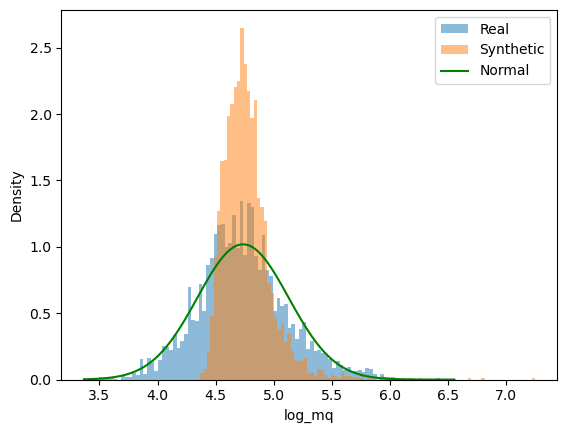

In [35]:
plt.hist(df_real['log_mq'], bins=100, alpha=0.5, label='Real', density=True)
plt.hist(df_sample['log_mq'], bins=100, alpha=0.5, label='Synthetic', density=True)
# plot pdf of normal distribution
plt.plot(np.linspace(df_real['log_mq'].min(), df_real['log_mq'].max(), 100),
            scipy.stats.norm.pdf(np.linspace(df_real['log_mq'].min(), df_real['log_mq'].max(), 100),
                                  loc=np.mean(df_real['log_mq']),
                                  scale=np.std(df_real['log_mq'])),label='Normal', color='green')


#plt.hist(df_feat_shuffle['log_mq'], bins=100, alpha=0.5, label='Feature shuffled', density=True)
plt.xlabel('log_mq')
plt.ylabel('Density')
plt.legend()

## Chi square: for dummies

In [32]:
print('value counts_real:',df_real['flag_multi_floor'].value_counts())
print('value counts_sample:',df_sample['flag_multi_floor'].value_counts())

attribute_dummy = ['flag_garage', 'flag_air_conditioning', 'flag_multi_floor', 'flag_pertinenza',
                   'High_energy_class', 'Low_energy_class', 'Medium_energy_class',
       'Missing_energy_class']
df_chi= pd.DataFrame(columns=['chi2', 'p_value'], index=attribute_dummy)
# chi-squared test for independence
from scipy.stats import chi2_contingency
for attribute in attribute_dummy:
    contingency_table = pd.crosstab(df_real[attribute], df_sample[attribute])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    df_chi.loc[attribute,:] = [chi2, p_value]
    # Null hypothesis: two distributions are the same
    # Reject null hypothesis if p-value < 0.05:  two distributions are different

df_chi

value counts_real: flag_multi_floor
0.0    4212
1.0      10
Name: count, dtype: int64
value counts_sample: flag_multi_floor
False    4211
True       11
Name: count, dtype: int64


,chi2,p_value
flag_garage,0.851378,0.356163
flag_air_conditioning,0.395828,0.529252
flag_multi_floor,0.0,1.0
flag_pertinenza,0.127777,0.720748
High_energy_class,0.0,1.0
Low_energy_class,0.151847,0.696777
Medium_energy_class,0.0,1.0
Missing_energy_class,0.136883,0.7114


## Wasserstein distance between cells in grids: 

In [ ]:
import ot 
SWD_real_sample = ot.sliced_wasserstein_distance(grid_real.loc[:, ['x', 'y']].to_numpy(), 
                               grid_sample.loc[:, ['x', 'y']].to_numpy(), 
                               grid_real.num_homes.to_numpy(), 
                               grid_sample.num_homes.to_numpy(), 
                               n_projections=5000)

SWD_sample_null = ot.sliced_wasserstein_distance(grid_sample.loc[:, ['x', 'y']].to_numpy(), 
                               grid_null.loc[:, ['x', 'y']].to_numpy(), 
                               grid_sample.num_homes.to_numpy(), 
                               grid_null.num_homes.to_numpy(), 
                               n_projections=5000)

SWD_real_null = ot.sliced_wasserstein_distance(grid_real.loc[:, ['x', 'y']].to_numpy(), 
                               grid_null.loc[:, ['x', 'y']].to_numpy(), 
                               grid_real.num_homes.to_numpy(), 
                               grid_null.num_homes.to_numpy(), 
                               n_projections=5000)

SWD_real_abl= ot.sliced_wasserstein_distance(grid_real.loc[:, ['x', 'y']].to_numpy(), 
                                    grid_ablation.loc[:, ['x', 'y']].to_numpy(), 
                                    grid_real.num_homes.to_numpy(), 
                                    grid_ablation.num_homes.to_numpy(), 
                                    n_projections=5000)


print (f"SWD real vs sample: {SWD_real_sample}", 
       f"SWD sample vs null: {SWD_sample_null}", 
       f"SWD real vs null: {SWD_real_null}")
print (f"SWD real vs ablation: {SWD_real_abl}")

#10000: 0.007543662781693349 23s
#1000: 0.007559389314730181 1.7s
#5000: 0.007512275448032315 9s 


In [ ]:
import scipy.stats as stats
WD_scipy = stats.wasserstein_distance_nd(u_values = grid_list_real.loc[:, ['x', 'y']].to_numpy(), v_values= grid_list_null.loc[:, ['x', 'y']].to_numpy(), u_weights= grid_list_real.num_homes.to_numpy(), v_weights=grid_list_null.num_homes.to_numpy())
WD_scipy

In [ ]:
import scipy.stats as stats
WD_scipy_real_samp = stats.wasserstein_distance_nd(u_values = grid_list_real.loc[:, ['x', 'y']].to_numpy(), v_values= grid_list_sample.loc[:, ['x', 'y']].to_numpy(), u_weights= grid_list_real.num_homes.to_numpy(), v_weights=grid_list_sample.num_homes.to_numpy())
WD_scipy_real_samp

In [ ]:
province_shapefile

In [20]:
def Shuffle_attribute(grid_list,province_shapefile):
    
    # Find grid cells inside the province
    merged = gpd.sjoin(grid_list, province_shapefile, how='left', predicate='within')
    merged['in_province']= (~merged.index_right0.isna()).astype(int)
    grid_in_province=merged.drop(columns=['index_right0','index'])
    
    # Shuffle attribute num_homes in the grid cells that are inside the province
    grid_shuffled= merged.copy(deep=True)
    grid_shuffled.loc[grid_shuffled.in_province==1,'num_homes'] = np.random.permutation(grid_shuffled.loc[grid_shuffled.in_province==1,'num_homes'].values)
    return grid_shuffled, grid_in_province


# Shuffle num_homes in the grid cells that are inside the province
grid_real_shuffled, grid_province_real = Shuffle_attribute(grid_list_real, province_shapefile)
grid_sample_shuffled, grid_province_sample  = Shuffle_attribute(grid_list_sample, province_shapefile)
grid_sample_shuffled

,x,y,geometry,num_homes,index_right0,index,in_province
0,12.75119,43.204906,"POLYGON ((12.756 43.21, 12.756 43.2, 12.746 43...",0.0,NaN,NaN,0
1,12.75119,43.214906,"POLYGON ((12.756 43.22, 12.756 43.21, 12.746 4...",0.0,NaN,NaN,0
2,12.75119,43.224906,"POLYGON ((12.756 43.23, 12.756 43.22, 12.746 4...",0.0,NaN,NaN,0
3,12.75119,43.234906,"POLYGON ((12.756 43.24, 12.756 43.23, 12.746 4...",0.0,NaN,NaN,0
4,12.75119,43.244906,"POLYGON ((12.756 43.25, 12.756 43.24, 12.746 4...",0.0,NaN,NaN,0
...,...,...,...,...,...,...,...
5203,13.67119,43.714906,"POLYGON ((13.676 43.72, 13.676 43.71, 13.666 4...",0.0,NaN,NaN,0
5204,13.67119,43.724906,"POLYGON ((13.676 43.73, 13.676 43.72, 13.666 4...",0.0,NaN,NaN,0
5205,13.67119,43.734906,"POLYGON ((13.676 43.74, 13.676 43.73, 13.666 4...",0.0,NaN,NaN,0
5206,13.67119,43.744906,"POLYGON ((13.676 43.75, 13.676 43.74, 13.666 4...",0.0,NaN,NaN,0


In [ ]:
# compute distance matrix for shuffled
import ot 
SWD_real_shuff_in = ot.sliced_wasserstein_distance(grid_province_real.loc[grid_province_real.in_province==1, ['x', 'y']].to_numpy(), 
                               grid_real_shuffled.loc[grid_real_shuffled.in_province==1, ['x', 'y']].to_numpy(), 
                               grid_province_real.loc[grid_province_real.in_province==1, 'num_homes'].to_numpy(), 
                               grid_real_shuffled.loc[grid_real_shuffled.in_province==1, 'num_homes'].to_numpy(), 
                               n_projections=5000)

SWD_real_shuff_all = ot.sliced_wasserstein_distance(grid_province_real.loc[:, ['x', 'y']].to_numpy(), 
                               grid_real_shuffled.loc[:, ['x', 'y']].to_numpy(), 
                               grid_province_real.loc[:, 'num_homes'].to_numpy(), 
                               grid_real_shuffled.loc[:, 'num_homes'].to_numpy(), 
                               n_projections=5000)


SWD_sample_shuff_in = ot.sliced_wasserstein_distance(grid_province_sample.loc[grid_province_sample.in_province==1, ['x', 'y']].to_numpy(), 
                               grid_sample_shuffled.loc[grid_sample_shuffled.in_province==1, ['x', 'y']].to_numpy(), 
                               grid_province_sample.loc[grid_province_sample.in_province==1, 'num_homes'].to_numpy(), 
                               grid_sample_shuffled.loc[grid_sample_shuffled.in_province==1, 'num_homes'].to_numpy(), 
                               n_projections=5000)

SWD_sample_shuff_all = ot.sliced_wasserstein_distance(grid_province_sample.loc[:, ['x', 'y']].to_numpy(),
                                    grid_sample_shuffled.loc[:, ['x', 'y']].to_numpy(), 
                                    grid_province_sample.loc[:, 'num_homes'].to_numpy(), 
                                    grid_sample_shuffled.loc[:, 'num_homes'].to_numpy(), 
                                    n_projections=5000)
'''
SWD_real_shuff = ot.sliced_wasserstein_distance(grid_list_real.loc[:, ['x', 'y']].to_numpy(), 
                               grid_real_shuffled.loc[:, ['x', 'y']].to_numpy(), 
                               grid_list_real.num_homes.to_numpy(), 
                               grid_real_shuffled.num_homes.to_numpy(), 
                               n_projections=5000)

SWD_sample_shuff = ot.sliced_wasserstein_distance(grid_list_sample.loc[:, ['x', 'y']].to_numpy(), 
                               grid_sample_shuffled.loc[:, ['x', 'y']].to_numpy(), 
                               grid_list_sample.num_homes.to_numpy(), 
                               grid_sample_shuffled.num_homes.to_numpy(), 
                               n_projections=5000)'''

print(f"SWD Real vs Real shuffled (IN PROV): {SWD_real_shuff_in}", f"SWD Real vs Real shuffled (ALL): {SWD_real_shuff_all}")
print(f"SWD Sample vs Sample shuffled (IN PROV): {SWD_sample_shuff_in}", f"SWD Sample vs Sample shuffled (ALL): {SWD_sample_shuff_all}")

SWD Real vs Real shuffled (IN PROV): 0.12686748284984015 SWD Real vs Real shuffled (ALL): 0.11881409772285519
SWD Sample vs Sample shuffled (IN PROV): 0.11941721671887812 SWD Sample vs Sample shuffled (ALL): 0.11014159652932319


### ER scipy

In [ ]:
import scipy.stats as stats #not working 
def sliced_wasserstein(X, Y, num_proj):
    '''Takes:
        X: 2d (or nd) histogram
        Y: 2d (or nd) histogram
        num_proj: Number of random projections to compute the mean over
        ---
        returns:
        mean_emd_dist'''
    #% Implementation of the (non-generalized) sliced wasserstein (EMD) for 2d distributions as described here: https://arxiv.org/abs/1902.00434 %#
    # X and Y should be a 2d histogram 
    # Code adapted from stackoverflow user: Dougal - https://stats.stackexchange.com/questions/404775/calculate-earth-movers-distance-for-two-grayscale-images
    dim = X.shape[1]
    ests = []
    
    for x in range(num_proj):
        
        # sample uniformly from the unit sphere
        dir = np.random.rand(dim)
        dir /= np.linalg.norm(dir)

        # project the data
        X_proj = X @ dir
        Y_proj = Y @ dir
        
        # compute 1d wasserstein
        ests.append(stats.wasserstein_distance(np.arange(dim), np.arange(dim), X_proj, Y_proj))
    return np.mean(ests)


sliced_wasserstein(grid_real.to_numpy(), grid_sample.to_numpy(), num_proj=100)